In [1]:
from caseva.models import BlockMaximaModel, ThresholdExcessModel
import pandas as pd

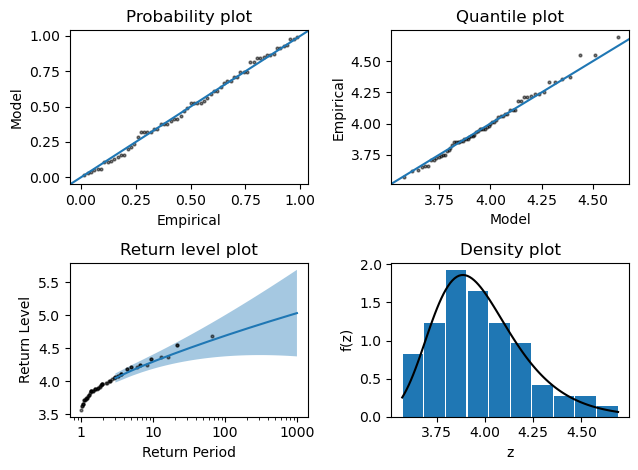

In [2]:
data = pd.read_csv("../data/portpirie.csv")

extremes = data["SeaLevel"]

# Coles (2001) p.59 Examples 3.4.1.
model = BlockMaximaModel(extremes=extremes)
model.fit()
model.model_evaluation_plot()

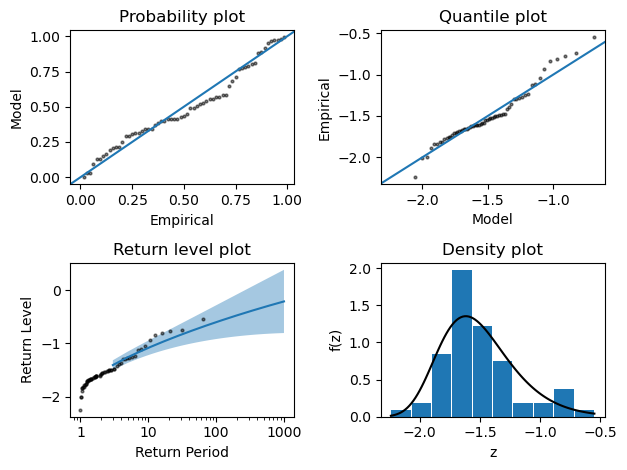

In [3]:
data = pd.read_csv("../data/glass.csv")

extremes = -data["Strength"]

# Coles (2001) p.59 Examples 3.4.1.
model = BlockMaximaModel(extremes=extremes)
model.fit()
model.model_evaluation_plot()

In [10]:
import numpy as np

In [13]:
np.round(model.covar, 6)

array([[ 0.001408,  0.000214, -0.000795],
       [ 0.000214,  0.000652, -0.000441],
       [-0.000795, -0.000441,  0.004893]])

In [7]:
model.theta

array([-1.64162644,  0.27286361, -0.08434668])

model

In [6]:
1-1/1.01

0.00990099009900991

In [3]:
import numpy as np
np.log(1)

np.float64(0.0)

In [9]:
np.linspace(1.1, 1000, 500)

array([   1.1       ,    3.10180361,    5.10360721,    7.10541082,
          9.10721443,   11.10901804,   13.11082164,   15.11262525,
         17.11442886,   19.11623246,   21.11803607,   23.11983968,
         25.12164329,   27.12344689,   29.1252505 ,   31.12705411,
         33.12885772,   35.13066132,   37.13246493,   39.13426854,
         41.13607214,   43.13787575,   45.13967936,   47.14148297,
         49.14328657,   51.14509018,   53.14689379,   55.14869739,
         57.150501  ,   59.15230461,   61.15410822,   63.15591182,
         65.15771543,   67.15951904,   69.16132265,   71.16312625,
         73.16492986,   75.16673347,   77.16853707,   79.17034068,
         81.17214429,   83.1739479 ,   85.1757515 ,   87.17755511,
         89.17935872,   91.18116232,   93.18296593,   95.18476954,
         97.18657315,   99.18837675,  101.19018036,  103.19198397,
        105.19378758,  107.19559118,  109.19739479,  111.1991984 ,
        113.201002  ,  115.20280561,  117.20460922,  119.20641

ValueError: x and y must have same first dimension, but have shapes (500,) and (1,)

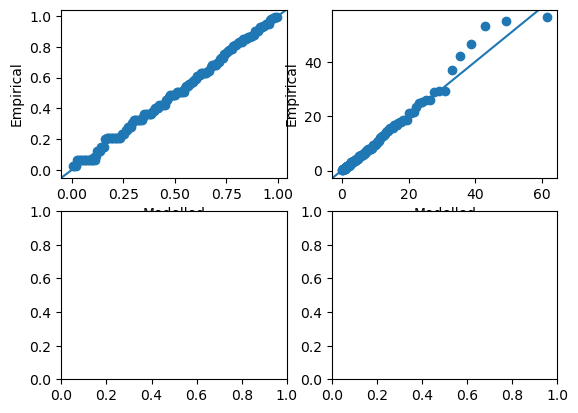

In [3]:
data = pd.read_csv("../data/rain.csv", parse_dates=[0])
years = [date.year for date in data["Date"]]
num_years = max(years) - min(years) + 1
threshold = 30

model = ThresholdExcessModel(
    data=data["Rainfall"], threshold=threshold, num_years=num_years)

model.fit()
model.model_evaluation_plot()



In [4]:
import numpy as np

In [12]:
-1/np.log(2000) / 2001

np.float64(-6.574878806794198e-05)

In [ ]:
points(-1/log(
    (1:length(dat))/(length(dat) + 1)
), sort(dat))